In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load test module for sanity check
from test_utils import test

Data Generation
===

In [2]:
from numpy.random import rand, randn

In [3]:
n, d, k = 100, 2, 2

In [5]:
np.random.seed(20)
X = rand(n, d)

# means = [rand(d)  for _ in range(k)]  # works for any k
means = [rand(d) * 0.5 + 0.5, -rand(d) * 0.5 + 0.5]  # for better plotting when k = 2

S = np.diag(rand(d))

sigmas = [S] * k  # we'll use the same Sigma for all clusters for better visual results

print(means)
print(sigmas)

[array([0.69872366, 0.75176984]), array([0.25997411, 0.14504062])]
[array([[0.01764816, 0.        ],
       [0.        , 0.06360523]]), array([[0.01764816, 0.        ],
       [0.        , 0.06360523]])]


## Computing the probability density

In [ ]:
def compute_p(X, mean, sigma):
    """
    Compute the probability of each data point in X under a Gaussian distribution

    Args:
        X: (n, d) numpy array, where each row corresponds to a data point
        mean: (d, ) numpy array, the mean of the Gaussian distribution
        sigma: (d, d) numpy array, the covariance matrix of the Gaussian distribution

    Returns:
        p: (n, ) numpy array, the probability of each data point

    >>> compute_p(np.array([[0, 0], [1, 1]]), np.array([0, 0]), np.eye(2))
    array([0.15915494, 0.05854983])
    """

    d = X.shape[1]
    dxm = X - mean
    const = 1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(sigma))

    ###############################
    # Option 1: elementwise (Hadamard) multiplication via * operation
    ###############################
    # np.dot(dxm, np.linalg.inv(sigma) gives a (n,d) matrix
    # dxm is of shape (n,d)
    # * is elementwise (Hadamard) multiplication, which gives elementwise multiplication
    # exponent = -0.5 * np.sum(dxm * np.dot(dxm, np.linalg.inv(sigma)), axis=1)

    ###############################
    # Option 2: matrix multiplication
    ###############################
    # Note after matrix multiplication, we have a gram matrix of shape (n,n)
    # we only need the diagonal entries 
    # 1) using np.dot or dot()
    # exponent = -0.5 * (np.dot(np.dot(dxm, np.linalg.inv(sigma)), dxm.transpose())).diagonal()
    # equivalently,
    # exponent = -0.5 * (dxm.dot(np.linalg.inv(sigma)).dot(dxm.transpose())).diagonal()
    # 2) using @ operator
    # exponent = -0.5 * ((dxm @ np.linalg.inv(sigma)) @ dxm.transpose()).diagonal()
    # return const * np.exp(exponent)


    ###############################
    # Option 3: iteration through all data points
    ###############################
    [n, d] = np.shape(X)
    invSigma = np.linalg.inv(sigma)

    result = np.zeros((n,))
    for i in range(n):
        xmu = X[i] - mean # shape (d,)
        result[i] = const * np.exp(-0.5 * (xmu).T.dot(invSigma).dot(xmu))
    return result

    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION


test(compute_p)

❌ The are some issues with your implementation of `compute_p`:
**********************************************************************
File "__main__", line 13, in compute_p
Failed example:
    compute_p(np.array([[0, 0], [1, 1]]), np.array([0, 0]), np.eye(2))
Expected:
    array([0.15915494, 0.05854983])
Got:
    (2,)
    (2,)
    array([0.15915494, 0.05854983])
**********************************************************************


In [17]:
X[:,0] -mean

array([0, 1])

In [25]:
X = np.array([[0, 0], [1, 1]])
mean =  np.array([0, 0])
sigma = np.eye(2)
res = 0
for i in range(2):
    const = 1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(sigma))
    exponent = -0.5 * (X[i,:]-mean) * np.dot((X[i,:]-mean), np.linalg.inv(sigma))
    print(const, exponent)
    res += const * np.exp(exponent)
print(res/2)

0.15915494309189535 [-0. -0.]
0.15915494309189535 [-0.5 -0.5]
[0.12784365 0.12784365]


In [6]:
ps = [
    compute_p(X, m, s) for m, s in zip(means, sigmas)
]  # exercise: try to do this without looping

In [7]:
assignments = np.argmax(ps, axis=0)
print(assignments)

[0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0
 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0]


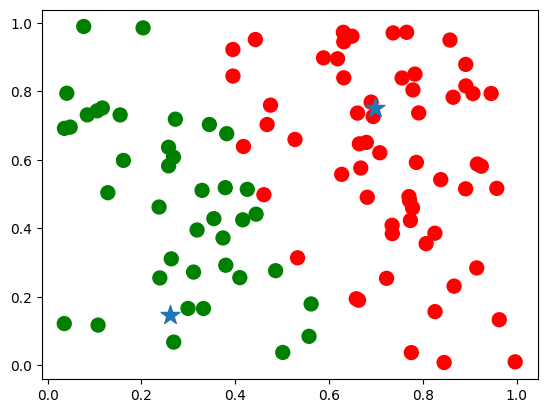

In [8]:
colors = np.array(["red", "green"])[assignments]
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)
plt.scatter(np.array(means)[:, 0], np.array(means)[:, 1], marker="*", s=200)
plt.show()

Solution
===

In [9]:
def compute_log_p(X, mean, sigma):
    """
    Compute the log probability of each data point in X under a Gaussian distribution

    Args:
        X: (n, d) numpy array, where each row corresponds to a data point
        mean: (d, ) numpy array, the mean of the Gaussian distribution
        sigma: (d, d) numpy array, the covariance matrix of the Gaussian distribution

    Returns:
        log_p: (n, ) numpy array, the log probability of each data point

    >>> compute_log_p(np.array([[0, 0], [1, 1]]), np.array([0, 0]), np.eye(2))
    array([-1.83787707, -2.83787707])
    """
    ### SOLUTION
    d = X.shape[1]
    dxm = X - mean
    exponent = -0.5 * np.sum(dxm * np.dot(dxm, np.linalg.inv(sigma)), axis=1)
    return exponent - np.log(2 * np.pi) * (d / 2) - 0.5 * np.log(np.linalg.det(sigma))

    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION


test(compute_log_p)

✅ Your `compute_log_p` passed 1 tests.


In [10]:
log_ps = [
    compute_log_p(X, m, s) for m, s in zip(means, sigmas)
]  # exercise: try to do this without looping

In [11]:
assignments = np.argmax(log_ps, axis=0)
print(assignments)

[0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0
 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0]


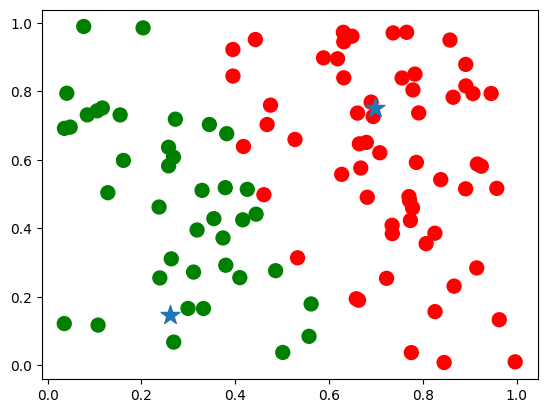

In [12]:
colors = np.array(["red", "green"])[assignments]
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)
plt.scatter(np.array(means)[:, 0], np.array(means)[:, 1], marker="*", s=200)
plt.show()